In [1]:
import os
from classes.VQVAE import VQVAE

import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import MNIST
from torchvision.transforms import Compose,ToTensor,Resize,PILToTensor
from torchvision.io import read_image
from torchsummary import summary

from torch import distributions as D
import wandb

from imutils import paths
import matplotlib.pyplot as plt
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: matteoferrante (use `wandb login --relogin` to force relogin)


True

In [26]:
encoder_architecture=[[3,256],[1,256],[1,128],[1,64]]
decoder_architecture=[[1,64],[1,128],[1,256],[3,256]]



latent_dim=512
input_dim=(3,128,128)

num_embeddings=512


config={"dataset":"celebA", "type":"VQ-VAE","encoder_architecture":encoder_architecture,"decoder_architecture":decoder_architecture}
config["latent_dim"]=latent_dim
config["input_dim"]=input_dim

model=VQVAE(input_dim=input_dim,latent_dim=latent_dim,num_embeddings=num_embeddings,encoder_architecture=encoder_architecture,decoder_architecture=decoder_architecture)

/home/matteo/anaconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [27]:
x=torch.randn(2,3,128,128)

l,x2,p=model(x)

x2.shape

torch.Size([2, 3, 128, 128])

In [28]:
summary(model.encoder,(3,128,128),device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 256, 64, 64]          12,544
            Conv2d-2          [-1, 256, 64, 64]         590,080
       BatchNorm2d-3          [-1, 256, 64, 64]             512
            Conv2d-4          [-1, 256, 64, 64]         590,080
       BatchNorm2d-5          [-1, 256, 64, 64]             512
              ReLU-6          [-1, 256, 64, 64]               0
            Conv2d-7          [-1, 256, 64, 64]         590,080
       BatchNorm2d-8          [-1, 256, 64, 64]             512
         LeakyReLU-9          [-1, 256, 64, 64]               0
    ResidualBlock-10          [-1, 256, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]         590,080
      BatchNorm2d-12          [-1, 256, 64, 64]             512
           Conv2d-13          [-1, 256, 64, 64]         590,080
      BatchNorm2d-14          [-1, 256,

In [29]:
summary(model.decoder,(latent_dim,4,4),device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1             [-1, 64, 8, 8]         524,352
             PReLU-2             [-1, 64, 8, 8]               1
            Conv2d-3             [-1, 64, 8, 8]          36,928
       BatchNorm2d-4             [-1, 64, 8, 8]             128
            Conv2d-5             [-1, 64, 8, 8]          36,928
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,928
       BatchNorm2d-9             [-1, 64, 8, 8]             128
        LeakyReLU-10             [-1, 64, 8, 8]               0
    ResidualBlock-11             [-1, 64, 8, 8]               0
ConvTransposeResBlock-12             [-1, 64, 8, 8]               0
  ConvTranspose2d-13          [-1, 128, 16, 16]         131,200
            PReLU-14          [-1, 

In [30]:
images_dir=r"C:\Users\matte\Dataset\tor_vergata\Dataset\Img\img_align_celeba"
images_dir=r"/home/matteo/NeuroGEN/Dataset/Img/img_align_celeba"

#other important definitions

EPOCHS=32
BS=64
INIT_LR=1e-4

config["epochs"]=EPOCHS
config["BS"]=BS
config["init_lr"]=INIT_LR


In [31]:
class ImageDataset(Dataset):
    def __init__(self, img_list, transform=None):
        self.img_list = img_list
        self.transform = transform

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        img_path = self.img_list[idx]
        image = read_image(img_path)
        if self.transform:
            image = self.transform(image)/255.
        return image

In [32]:
transforms=Compose([
 Resize((128,128)),
])



In [33]:
print("[INFO] loading image paths...")
imagePaths = list(paths.list_images(images_dir))


train_len=int(0.8*len(imagePaths))  #0.8
val_len=int(0.1*len(imagePaths))     #0.1
test_len=int(0.1*len(imagePaths))

train_imgs=imagePaths[:train_len]                                #      80% for training
val_imgs=imagePaths[train_len:train_len+val_len]                 #      10% for validation
test_imgs=imagePaths[train_len+val_len:]                         #      10% for testing

print(f"[TRAINING]\t {len(train_imgs)}\n[VALIDATION]\t {len(val_imgs)}\n[TEST]\t\t {len(test_imgs)}")

[INFO] loading image paths...
[TRAINING]	 138545
[VALIDATION]	 17318
[TEST]		 17319


In [34]:
train_dataset=ImageDataset(train_imgs,transform=transforms)
val_dataset=ImageDataset(val_imgs,transform=transforms)
test_dataset=ImageDataset(test_imgs,transform=transforms)

train_dataloader=DataLoader(train_dataset, batch_size=BS, shuffle=True)
val_dataloader=DataLoader(val_dataset, batch_size=BS)
test_dataloader=DataLoader(test_dataset, batch_size=BS)


## Train Loop

In [35]:
base_path="models/vqvae"
os.makedirs(base_path,exist_ok=True)

In [36]:
# Get cpu or gpu device for training.
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda:0 device


In [37]:
wandb.init(project="NeuroGEN_Pytorch",config=config)

loss,█▂▂▂▁▁▁▁▁▁
perplexity,▁▃▄▅▆▆▇▇██
recon_loss,█▂▂▂▁▁▁▁▁▁
val_loss,█▄▃▃▂▂▂▂▁▁
val_perplexity,▁▃▄▅▆▇▇▇██
val_recon_loss,█▄▃▃▂▂▂▂▁▁
loss,0.00333
perplexity,209.74281
recon_loss,0.00306
val_loss,0.0033
val_perplexity,208.18547


Epoch 0: 100%|█| 2165/2165 [54:56<00:00,  1.52s/batch, loss=0.00378, perplexity=
Val 0: 100%|█| 271/271 [02:30<00:00,  1.81batch/s, val_loss=0.00372, val_perplex


(38, 128, 128, 3) (38, 128, 128, 3)


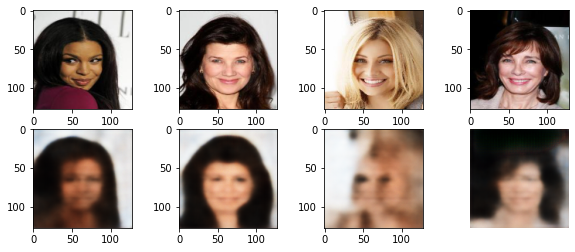

Epoch 1: 100%|█| 2165/2165 [54:56<00:00,  1.52s/batch, loss=0.00304, perplexity=
Val 1: 100%|█| 271/271 [02:27<00:00,  1.84batch/s, val_loss=0.00363, val_perplex


(38, 128, 128, 3) (38, 128, 128, 3)


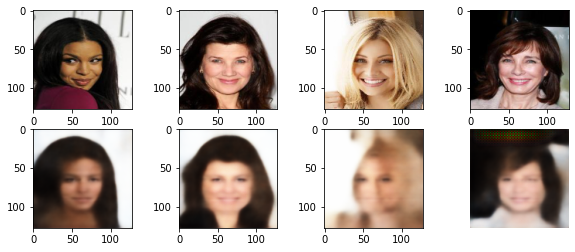

Epoch 2: 100%|█| 2165/2165 [54:55<00:00,  1.52s/batch, loss=0.00271, perplexity=
Val 2: 100%|█| 271/271 [02:27<00:00,  1.83batch/s, val_loss=0.00271, val_perplex


(38, 128, 128, 3) (38, 128, 128, 3)


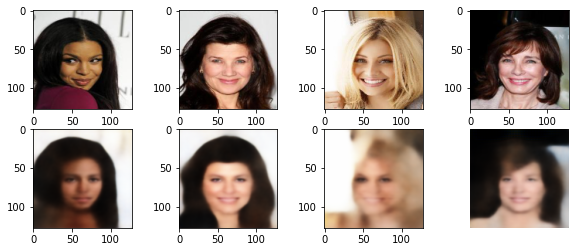

Epoch 3: 100%|█| 2165/2165 [54:58<00:00,  1.52s/batch, loss=0.00269, perplexity=
Val 3: 100%|█| 271/271 [02:28<00:00,  1.83batch/s, val_loss=0.00262, val_perplex


(38, 128, 128, 3) (38, 128, 128, 3)


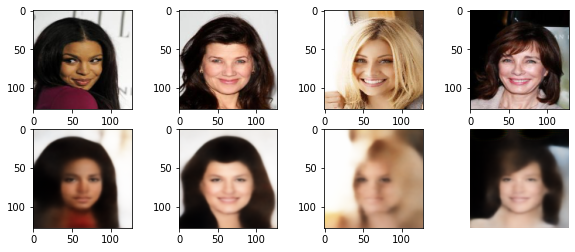

Epoch 4: 100%|█| 2165/2165 [54:54<00:00,  1.52s/batch, loss=0.00253, perplexity=
Val 4: 100%|█| 271/271 [02:27<00:00,  1.83batch/s, val_loss=0.00224, val_perplex


(38, 128, 128, 3) (38, 128, 128, 3)


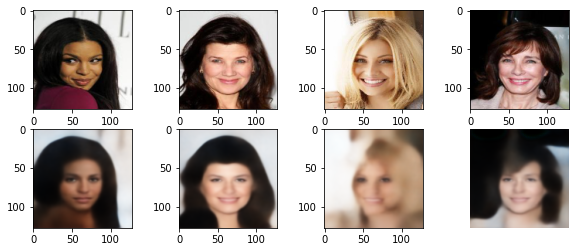

Epoch 5:  31%|▎| 669/2165 [16:57<37:52,  1.52s/batch, loss=0.00241, perplexity=4

In [ ]:

optimizer=torch.optim.Adam(model.parameters(),lr=INIT_LR)
model.to(device)

model.fit(train_dataloader=train_dataloader,val_dataloader=val_dataloader,epochs=EPOCHS,optimizer=optimizer,device=device,wandb_log=True,save_model=base_path,early_stop=3)

In [ ]:
torch.save(model.state_dict(), os.path.join(base_path,"model.pt"))
